In [163]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from mpl_toolkits.mplot3d import Axes3D

# Метод инерции (Momentum) - запоминаем информацию о прошлом шаге

Использует тренды предыдущих итераций, чтобы уменьшить вероятность попадания  в локальные минимумы. Метод нацелен на использование линейной комбинации градиента текущего шага и показателя сдвига с предыдущего шага.

Обновление весов учитывает не только текущий градиент, но и накопленный "импульс" от предыдущих шагов. Это достигается за счёт добавления экспоненциально затухающего среднего градиента:

## Формулы Momentum:
$
v_t = \beta v_{t-1} + (1 - \beta) \nabla L
$

$
w_t = w_{t-1} - \alpha v_t
$

Где:  
- $( v_t )$ — это вектор скорости (или инерции), который хранит "память" предыдущих градиентов,  
- $( \beta )$ — коэффициент сглаживания (обычно 0.9). коэффициент инерции, который контролирует, насколько сильно в следующем обновлении веса будет учитываться предыдущий градиент. Значение обычно выбирается в пределах [0, 1],
- $( \nabla L )$ — градиент текущей итерации,  
- $( \alpha )$ — learning rate,  
- $( w_t )$ — обновлённые веса.

In [164]:
def gradient_descent_momentum(
    steps: int,
    alpha: float,
    beta: float,
    X: np.ndarray,
    y: np.ndarray,
    w = None,
    eps=1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью градиентного спуска с инерцией (Momentum)

    Args:
        steps (int): количество итераций
        alpha (float): длина шага
        beta (float): коэффициент инерции
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    v = np.zeros(m)  # начальная скорость

    for _ in range(steps):
        
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        
        if np.sum(grad**2)**0.5 < eps:
            break
        
        v = beta * v + (1 - beta) * grad  # Обновляем скорость с учетом инерции
        w_cur -= alpha * v  # Делаем шаг весов с использованием инерции

        w_history.append(w_cur.copy())
        err_history.append(err.mean())
    
    print(w_cur)
    return w_cur, np.array(w_history), np.array(err_history)


# RMSprop

адаптирует learning rate для каждого параметра, уменьшая его для частых обновлений и увеличивая для редких.

Если градиент **большой** → шаг **уменьшается**.  

Если градиент **маленький** → шаг **увеличивается**.  

В отличие от AdaGrad, RMSprop не просто накапливает квадраты градиентов, а использует экспоненциальное сглаживание прошлых градиентов, что предотвращает слишком быстрое затухание learning rate.

Используется скользящее среднее квадратов градиента:

$
E[g^2]_t = \beta E[g^2]_{t-1} + (1 - \beta) g_t^2
$

$
w_t = w_{t-1} - \frac{\alpha}{\sqrt{E[g^2]_t + \epsilon}} g_t
$

Где:  
- $( E[g^2]_t )$ — скользящее среднее квадратов градиента. Это позволяет адаптировать скорость обучения для каждого параметра, учитывая, как часто он меняется,  
- $( \beta )$ — коэффициент сглаживания, обычно выбирается в диапазоне [0, 1]. Он определяет, насколько важно учитывать прошлые квадраты градиентов,
- $( g_t )$ — градиент на текущей итерации,  
- $( \alpha )$ — learning rate,  
- $( \epsilon )$ — небольшая добавка (обычно **1e-8**) для избежания деления на 0.  

**RMSprop уменьшает learning rate в направлениях с высоким градиентом** (чтобы избежать резких скачков) и **увеличивает его в более пологих направлениях** (чтобы ускорить сходимость). 

In [165]:
def gradient_descent_rmsprop(
    steps: int,
    alpha: float,
    beta: float,
    epsilon: float,
    X: np.ndarray,
    y: np.ndarray,
    w = None,
    eps=1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью градиентного спуска с методом RMSprop

    Args:
        steps (int): количество итераций
        alpha (float): начальная длина шага
        beta (float): коэффициент сглаживания для градиентов
        epsilon (float): малое значение для предотвращения деления на ноль
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    grad_squared_avg = np.zeros(m)  # Инициализация среднего квадрата градиентов

    for _ in range(steps):
        
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        
        grad_squared_avg = beta * grad_squared_avg + (1 - beta) * grad**2
        adjusted_grad = grad / (np.sqrt(grad_squared_avg) + epsilon)
        
        w_cur -= alpha * adjusted_grad

        w_history.append(w_cur.copy())
        err_history.append(err.mean())

        if np.sum(grad**2)**0.5 < eps:
            break
    
    print(w_cur)
    return w_cur, np.array(w_history), np.array(err_history)

# Adam — объединение метода инерции и RMSprop  

**Adam (Adaptive Moment Estimation)** — алгоритм оптимизации, который сочетает **Momentum** (инерцию) и **RMSprop** (адаптивный размер шага).  

1) **Momentum** помогает **учитывать прошлые градиенты** и делает обновления более плавными.  
2) **RMSprop** регулирует **размер шага**, предотвращая резкие скачки и адаптируясь к разным параметрам.  

Adam использует два скользящих среднего:  

- **Первая моментная оценка (средний градиент)** — аналог Momentum:  
  $
  m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
  $
- **Вторая моментная оценка (средний квадрат градиента)** — аналог RMSprop:  
  $
  v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
  $

Для устранения смещения используется **коррекция**:  
$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$

Обновление весов:  
$
w_t = w_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$

где

* m1 и m2 — это скользящие средние для первого и второго моментов, соответственно. Первый момент отслеживает среднее значение градиента, а второй момент отслеживает среднее значение квадратов градиента

* $\beta_1$ — коэффициент для сглаживания первого момента

* $\beta_2$ — коэффициент для сглаживания второго момента

* $\epsilon$ — это малое значение, добавляемое в знаменатель для предотвращения деления на ноль

* v — это корректированные значения первого и второго моментов, которые учитывают смещение в начале обучения. Это важно, чтобы избежать слишком маленьких значений для моментов на первых шагах

Почему он хорош?

* **Быстрая сходимость** благодаря Momentum.  
* **Адаптивный шаг** для разных параметров (RMSprop).  
* **Устойчивость к выбросам** и шуму в данных.  

**Стандартные параметры:**  
- $( \beta_1 = 0.9 )$ (для момента)  
- $( \beta_2 = 0.999 )$ (для RMSprop)  
- $( \epsilon = 10^{-8} )$ (для числовой стабильности)  



In [166]:
def gradient_descent_adam(
    steps: int, 
    alpha: float,
    beta1: float,
    beta2: float,
    epsilon: float,
    X: np.ndarray, 
    y: np.ndarray,
    w = None,
    eps=1,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Функция для оптимизации весов с помощью градиентного спуска с методом Adam

    Args:
        steps (int): количество итераций
        alpha (float): начальная длина шага
        beta1 (float): коэффициент сглаживания для первого момента (градиентов)
        beta2 (float): коэффициент сглаживания для второго момента (квадраты градиентов)
        epsilon (float): малое значение для предотвращения деления на ноль
        X (np.ndarray): Матрица объектов-признаков
        y (np.ndarray): Вектор таргетов
        w (_type_, optional): Начальное значение для весов. Defaults to None.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Возвращает полученные веса, вектор с историей весов и вектор с ошибками на каждой итерации
    """
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    
    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    
    m1 = np.zeros(m)  # Инициализация первого момента (скользящее среднее градиентов)
    m2 = np.zeros(m)  # Инициализация второго момента (скользящее среднее квадратов градиентов)
    
    v1 = np.zeros(m)  # Скорректированное среднее градиентов
    v2 = np.zeros(m)  # Скорректированное среднее квадратов градиентов

    for i in range(steps):
        
        y_pred = X.dot(w_cur)
        err = y_pred - y
        grad = 2 * X.T.dot(err) / n
        
        m1 = beta1 * m1 + (1 - beta1) * grad
        m2 = beta2 * m2 + (1 - beta2) * grad**2

        v1 = m1 / (1 - beta1**(i + 1))
        v2 = m2 / (1 - beta2**(i + 1))
        
        adjusted_grad = v1 / (np.sqrt(v2) + epsilon)  # Нормализованный градиент с использованием моментов

        w_cur -= alpha * adjusted_grad  # обновление весов

        w_history.append(w_cur.copy())
        err_history.append(err.mean())

        if np.sum(grad**2)**0.5 < eps:
            break
    
    print(w_cur)
    return w_cur, np.array(w_history), np.array(err_history)

# Сгенерирую синтетически матрицу X и вектор y:

Задан датасет $(X, y)$, где 
-  $y=(y_i)_{i=1}^N \in \mathbb{R}^N$ — вектор значений целевой переменной, 
-  $X=(x_i)_{i = 1}^N \in \mathbb{R}^{N \times D}, x_i \in \mathbb{R}^D$ — матрица объектов-признаков. 

а затем сравню результаты работы трех методов оптимизации

In [267]:
# размеры матрицы: строки, столбцы
n, m = 1000, 2

# веса
w_true = np.random.standard_normal(m)

# Генерация матрицы признаков X с распределением chi^2
df = 2  # Количество степеней свободы для распределения chi^2
X = np.random.chisquare(df, (n, m))  # Генерация случайных чисел по chi^2

# масштабирование для создания весов для каждого признака (для моделирования ситуации, когда разные признаки имеют разный "вес" )
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

# Генерация вектора откликов y с шумом
y = X.dot(w_true) + np.random.normal(0, 1, (n))

print("X:", X[:5], sep="\n")
print("y:", y[:5])

X:
[[ 0.23390788  7.9875873 ]
 [ 1.64706167  6.28192684]
 [ 1.41466468 32.09602194]
 [ 1.71518193  1.60254326]
 [ 1.51236317 11.18197213]]
y: [-0.51540684 -2.11982657  0.25347465 -0.50107445  0.02880231]


График 2D, отражающий только 2 веса (потому что изначально сгенерировала матрицу 1000 на 2)

In [268]:
def plot_weight_levels(X, y, histories, labels):
    plt.figure(figsize=(12, 8))
    
    w1_vals = np.linspace(min(min(h[:, 0]) for h in histories) - 1, max(max(h[:, 0]) for h in histories) + 1, 100)
    w2_vals = np.linspace(min(min(h[:, 1]) for h in histories) - 1, max(max(h[:, 1]) for h in histories) + 1, 100)
    
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)
    
    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) ** 2) / 2
    
    plt.contour(W1, W2, J_vals, levels=30, cmap='viridis')
    
    colors = ['red', 'blue', 'green']
    for history, label, color in zip(histories, labels, colors):
        plt.plot(history[:, 0], history[:, 1], marker='o', linestyle='-', color=color, label=label)
        plt.scatter(history[-1][0], history[-1][1], marker='*', s=200, color='black')
    
    plt.title('Веса и траектории')
    plt.xlabel('Вес 1')
    plt.ylabel('Вес 2')
    plt.legend()
    plt.show()

[-0.65104636  0.07837953]
[-0.64572228  0.08314044]
[-0.64982339  0.07739025]


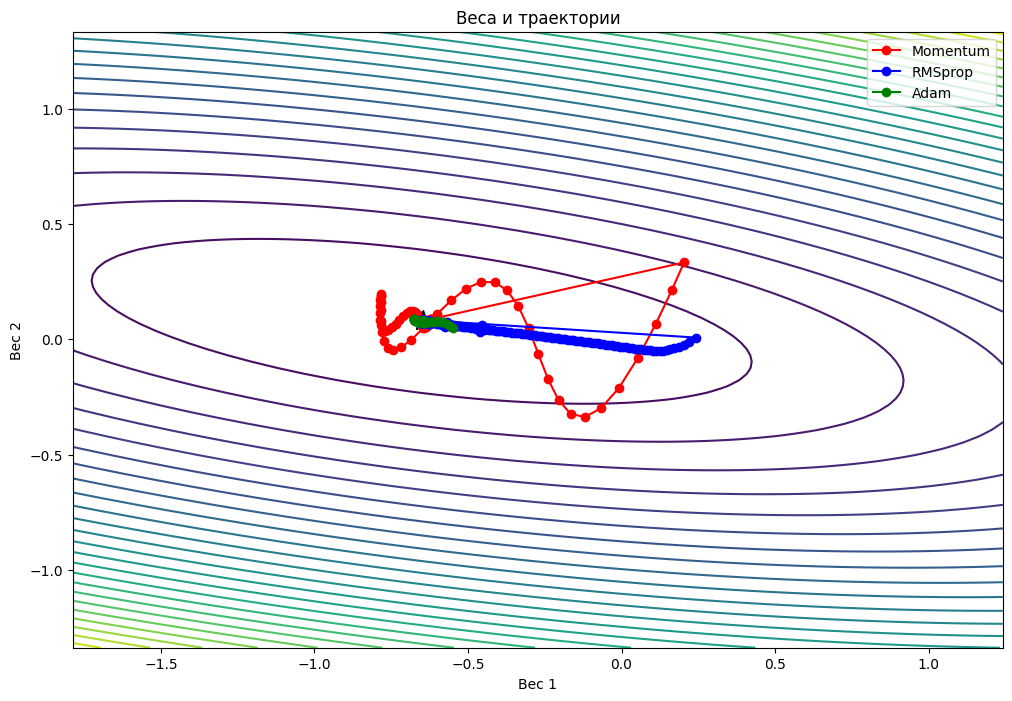

In [269]:
steps = 200
alpha = 0.01
beta = 0.9
epsilon = 1e-8
beta1, beta2 = 0.9, 0.999

# Выполнение трех методов
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X, y, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X, y, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X, y, eps=0.05)

# Визуализация
plot_weight_levels(X, y, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

Теперь построю 3D график (учет 3х весов), для начала сгенерирую новую матрицу 1000 на 3

In [208]:
# размеры матрицы: строки, столбцы
n, m = 1000, 3

# веса
w_true = np.random.standard_normal(m)

# Генерация матрицы признаков X_3 с распределением chi^2
df = 2  # Количество степеней свободы для распределения chi^2
X_3 = np.random.chisquare(df, (n, m))  # Генерация случайных чисел по chi^2

# масштабирование для создания весов для каждого признака (для моделирования ситуации, когда разные признаки имеют разный "вес" )
X_3 *= (np.arange(m) * 2 + 1)[np.newaxis, :]

# Генерация вектора откликов y с шумом
y_3 = X_3.dot(w_true) + np.random.normal(0, 1, (n))

print("X_3:", X_3[:5], sep="\n")
print("y_3:", y_3[:5])

X_3:
[[ 1.27745121  8.44948659  0.82225595]
 [ 9.0335889   0.22294768 13.50624288]
 [ 1.54577433  8.25700904  4.21792758]
 [ 0.06842711  3.94091626 14.50598601]
 [ 1.08090845  1.70610883  3.49387946]]
y_3: [ -5.31060705 -25.49571292 -10.4709283  -15.54081246  -3.13935806]


In [209]:
def plot_weight_levels_3d(X, y, histories, labels):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    w1_vals = np.linspace(min(min(h[:, 0]) for h in histories) - 1, max(max(h[:, 0]) for h in histories) + 1, 30)
    w2_vals = np.linspace(min(min(h[:, 1]) for h in histories) - 1, max(max(h[:, 1]) for h in histories) + 1, 30)
    w3_vals = np.linspace(min(min(h[:, 2]) for h in histories) - 1, max(max(h[:, 2]) for h in histories) + 1, 30)
    
    W1, W2, W3 = np.meshgrid(w1_vals, w2_vals, w3_vals)
    J_vals = np.zeros_like(W1)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            for k in range(W1.shape[2]):
                w_tmp = np.zeros(X.shape[1])
                w_tmp[:3] = [W1[i, j, k], W2[i, j, k], W3[i, j, k]]
                J_vals[i, j, k] = np.mean((X.dot(w_tmp) - y) ** 2) / 2

    colors = ['red', 'blue', 'green']
    
    for history, label, color in zip(histories, labels, colors):
        ax.plot(history[:, 0], history[:, 1], history[:, 2], marker='o', linestyle='-', color=color, label=label)
        ax.scatter(history[-1][0], history[-1][1], history[-1][2], marker='*', s=200, color='black')
    
    ax.set_title('3D веса и траектории')
    ax.set_xlabel('Вес 1')
    ax.set_ylabel('Вес 2')
    ax.set_zlabel('Вес 3')
    ax.legend()
    
# Вращение графика

    ax.view_init(elev=10, azim=30)

    plt.show()


In [ ]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_3, y_3, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_3, y_3, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_3, y_3, eps=0.05)

[-1.21798163 -0.40686597 -1.03488914]
[-1.22326434 -0.4122361  -1.03966486]
[ 0.5138041  -0.77322191 -0.99877986]


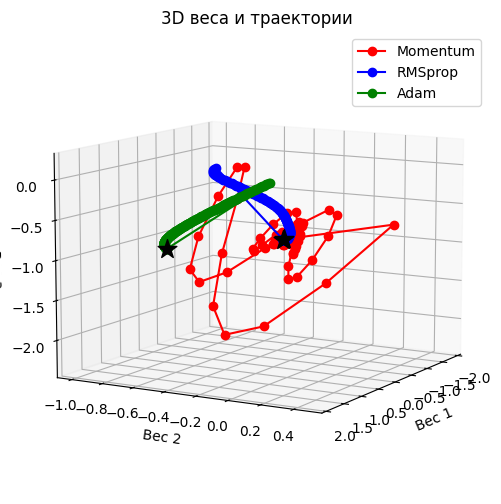

In [214]:
plot_weight_levels_3d(X, y, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

Применив все 3 метода, я заметила, что очень сильно влияет каждый запуск метода. У меня методы могли давать идентичные результаты, или наоборот все три разные. Но позапускав несколько раз, я заметила, что чаще всего ситуация такая:

* Для 2х весов: все 3 метода чаще дают идентичный результат, при заданных параметрах

* Для 3х весов: метод моментов и RMSprop дают одинаковый результат, а Adams - отличается

Думаю, это связано с тем, что когда всего 2 веса, то пространство поиска относительно простое, и градиентные методы работают достаточно стабильно. А также я нашла инфу, что вероятно, функция потерь в таких случаях гладкая, => влияние адаптивных скоростей обновления весов (как в RMSprop и Adam) не так сильно сказывается. И еще Adam в этом случае ведёт себя похоже на RMSprop, потому что влияние инерции (Momentum) не так заметно.

А вот в многомерном пространстве Adam сильнее адаптирует шаг для разных направлений, что может привести его к другой траектории и, как следствие, другому минимуму.

RMSprop и Momentum управляют обновлением весов тоже разными способами, поэтому я также находила между ними расхождения, но не так часто как с Adamom.

## Форма траекторий

Форма траектории метода моментов (петляющая) заметно отлчиается от траекторий Adam и RMSprop (более плавная и равномерная, как радуга/червяк). Потому что Momentum использует ускорение, накапливая градиенты предыдущих шагов. Если градиент в одном направлении сохраняется несколько шагов, скорость нарастает, и метод может "перелететь" через минимум. Когда градиент меняет направление (например, между минимумами), импульс ещё сохраняется, и веса делают колебания вокруг оптимального значения.

А вот RMSprop динамически регулирует шаг обучения, снижая его в направлениях с высокой изменчивостью градиента. Он затухает колебания, тк использует разделение градиента на его среднеквадратичное значение.

Adam похож на RMSprop, потому что это смесь Momentumа и RMSprop и именно затухание от наследует от RMSprop.

# Проверю еще на больших размерностях (4, 7, 15), но уже без визуализации

# m = 4

In [222]:
# размеры матрицы: строки, столбцы
n, m = 1000, 4

# веса
w_true = np.random.standard_normal(m)

# Генерация матрицы признаков X_4 с распределением chi^2
df = 2  # Количество степеней свободы для распределения chi^2
X_4 = np.random.chisquare(df, (n, m))  # Генерация случайных чисел по chi^2

# масштабирование для создания весов для каждого признака (для моделирования ситуации, когда разные признаки имеют разный "вес" )
X_4 *= (np.arange(m) * 2 + 1)[np.newaxis, :]

# Генерация вектора откликов y с шумом
y_4 = X_4.dot(w_true) + np.random.normal(0, 1, (n))

print("X_4:", X_4[:5], sep="\n")
print("y_4:", y_4[:5])

X_4:
[[ 0.61297779  7.67417304  8.5872642  13.57974162]
 [ 2.32688914  0.83693055  8.53219259 16.97828517]
 [ 2.59561001  0.7277705   9.15230836  8.99622601]
 [ 1.87674657  6.33196911  2.33100327 11.92477337]
 [ 6.71887918  3.96174826  2.97721039  9.9540882 ]]
y_4: [14.78568143 20.05137463  8.75686375 13.58179784 13.41789035]


In [ ]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_4, y_4, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_4, y_4, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_4, y_4, eps=0.05)

[ 0.40633322 -0.31511371 -0.44245544  1.3437343 ]
[ 0.40124035 -0.32026075 -0.44743531  1.33887612]
[-0.72472036  0.12664774  0.4669949   0.39491846]


# m = 7

In [248]:
# размеры матрицы: строки, столбцы
n, m = 1000, 7

# веса
w_true = np.random.standard_normal(m)

# Генерация матрицы признаков X_7 с распределением chi^2
df = 2  # Количество степеней свободы для распределения chi^2
X_7 = np.random.chisquare(df, (n, m))  # Генерация случайных чисел по chi^2

# масштабирование для создания весов для каждого признака (для моделирования ситуации, когда разные признаки имеют разный "вес" )
X_7 *= (np.arange(m) * 2 + 1)[np.newaxis, :]

# Генерация вектора откликов y с шумом
y_7 = X_7.dot(w_true) + np.random.normal(0, 1, (n))

print("X_7:", X_7[:5], sep="\n")
print("y_7:", y_7[:5])

X_7:
[[ 1.61076231  0.40418196  0.72876668  8.99269337 39.32644581 54.38477632
  23.56252727]
 [ 1.65466759  2.68080989 20.69953208 11.93049288  1.58646753  3.99982956
   1.66928624]
 [ 4.80273312  1.11140502  6.60031929  4.75578673  1.93499724  1.54893736
  28.15277307]
 [ 3.57286599 14.34194152  1.87827836 37.45176815 26.07928376  8.63531232
  14.39917431]
 [ 1.81321623  2.0807667  15.62325478 10.602243    2.63620596  9.50523462
   8.69690399]]
y_7: [ 41.7707134  -27.48925066 -27.46481799  75.94843826 -22.6589503 ]


In [ ]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_7, y_7, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_7, y_7, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_7, y_7, eps=0.05)

[1.45347228e+75 4.09317994e+75 7.85727483e+75 1.03790321e+76
 1.46254421e+76 1.87105608e+76 2.67705175e+76]
[ 1.81602998  1.05391001 -1.8874759   0.55234603  0.7102374   0.13984384
 -0.58633707]
[ 0.90530015  0.3449312  -2.2150656   1.19805427  1.08973842  0.04473586
 -0.67396968]


При больших размерностях у метода инерции происходит взрыв градиентов (получаем огромные значения), потому что метод моментов использует накопленный градиент. Чтобы этого избежать, можно: уменьшить шаг обучения (learning rate), поменять β (момент инерции) или меньшее кол - во шагов, этим я замусь ниже. А RMSprop и Adam дают адекватные результаты, но разные значения весов. Потому что как я писала выше, они используют разные методы адаптивного изменения шага обучения:

* RMSprop нормализует градиент на основе среднего квадратичного значения прошлых градиентов, что помогает избежать больших скачков и стабилизировать обучение.

* Adam сочетает идеи моментума и RMSprop, что делает его более гибким. Он использует два накопителя: один для среднего градиента (как у моментума) и один для квадрата градиента (как у RMSprop).

# m = 15

In [250]:
# размеры матрицы: строки, столбцы
n, m = 1000, 15

# веса
w_true = np.random.standard_normal(m)

# Генерация матрицы признаков X_15 с распределением chi^2
df = 2  # Количество степеней свободы для распределения chi^2
X_15 = np.random.chisquare(df, (n, m))  # Генерация случайных чисел по chi^2

# масштабирование для создания весов для каждого признака (для моделирования ситуации, когда разные признаки имеют разный "вес" )
X_15 *= (np.arange(m) * 2 + 1)[np.newaxis, :]

# Генерация вектора откликов y с шумом
y_15 = X_15.dot(w_true) + np.random.normal(0, 1, (n))

print("X_15:", X_15[:5], sep="\n")
print("y_15:", y_15[:5])

X_15:
[[1.48519349e-01 1.45769043e+00 4.72415205e+00 7.58334379e+00
  7.05352219e+00 3.63638290e+01 8.31686348e+01 5.31631916e+00
  3.08492035e+00 1.18313116e+01 2.73680439e+01 3.25294630e+01
  2.69259717e+02 8.17009168e+00 1.38059379e+02]
 [7.35565528e-01 9.70378393e+00 5.20835231e-01 1.34672802e+01
  1.76233788e+01 3.01821670e-01 2.16014473e+01 5.68940473e+01
  1.47276599e+01 2.21164169e+01 7.43914663e+01 3.47837250e+00
  4.24491493e+01 1.36949830e+02 5.63567377e+01]
 [6.08931246e+00 1.20635687e+01 3.23553667e+00 1.19130240e+00
  2.02665221e+01 1.66704697e+00 1.08071981e+01 9.86562605e+00
  3.16589877e+01 1.10724383e+01 1.28877184e+01 1.86175503e+01
  3.95017609e+00 9.81882934e+01 1.23045366e+02]
 [1.40328732e+00 2.40083500e+00 5.70836700e-01 1.39873583e+01
  6.30760820e-02 6.71926395e+01 4.31849225e+01 1.98398165e+01
  2.06334172e+00 1.84696550e+01 3.06550791e+01 5.62563194e+00
  2.94464767e+01 8.92360223e+01 1.27208704e+02]
 [4.85164669e+00 5.86116824e+00 2.53206603e+01 1.25900250e

In [251]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_15, y_15, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_15, y_15, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_15, y_15, eps=0.05)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[-0.92653251 -0.50023591 -0.28652507 -0.18434077 -0.83534026  0.43388007
  0.02003644 -0.02013104 -0.25808746 -0.13551812 -0.60113845  0.89251364
 -0.32197028  0.43210018 -1.4795754 ]
[ 0.05342031 -0.6298013   0.19459274  0.50265174  0.38906761 -0.63981803
 -1.56424702  0.21387566 -1.27790391  0.09698137 -0.39982233  1.01247883
 -0.08912202  0.58977381 -1.34481969]


/var/folders/fr/1tb2j7g10s78g7qmxhtqjw1w0000gn/T/ipykernel_29039/2528328061.py:40: RuntimeWarning: overflow encountered in square
  if np.sum(grad**2)**0.5 < eps:
/Users/tatianasalamatova/reps/MTS_data_analysis/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/fr/1tb2j7g10s78g7qmxhtqjw1w0000gn/T/ipykernel_29039/2528328061.py:38: RuntimeWarning: overflow encountered in multiply
  grad = 2 * X.T.dot(err) / n
/var/folders/fr/1tb2j7g10s78g7qmxhtqjw1w0000gn/T/ipykernel_29039/2528328061.py:43: RuntimeWarning: invalid value encountered in add
  v = beta * v + (1 - beta) * grad  # Обновляем скорость с учетом инерции


Очевидно, что на больших размерностях с заданными мной параметрами все сломается:

* У моментума взрорвался градиент

* Произошло переполнение (overflow), когда возводили градиент в квадрат

* Результат X.T.dot(err) слишком большой, умножение на 2 только усугубило ситуацию

* Переполнение или nan в grad приводит к тому, что v тоже становится nan

# Теперь оставлю те же сгенерированные матрицы (2, 3, и 7 (потому что 10 и 15 ничего не поможет, там все падает)) и поменяю параметры у реализованных методов

### в списке параметров уменьшаю learning rate ($\alpha$)

In [252]:
steps = 200
alpha = 0.0001
beta = 0.9
epsilon = 1e-8
beta1, beta2 = 0.9, 0.999

## m = 2

[-0.65099535  0.0783605 ]
[-0.64781979  0.07766324]
[-0.64703783  0.07742964]


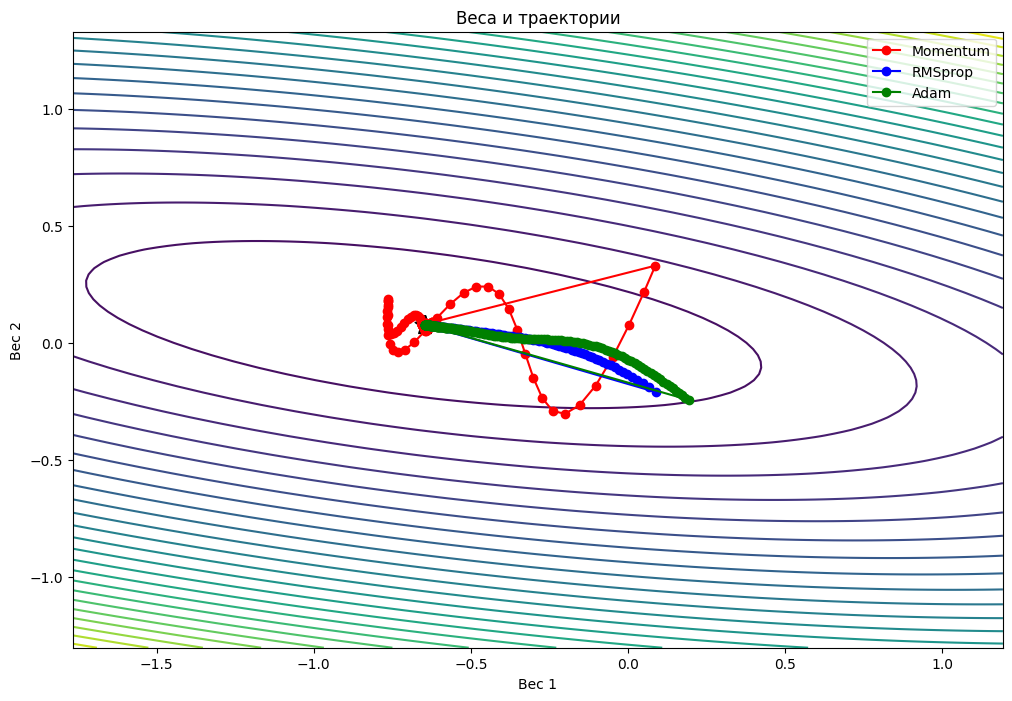

In [281]:
# Выполнение трех методов
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X, y, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X, y, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X, y, eps=0.05)

# Визуализация
plot_weight_levels(X, y, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

## m = 3

In [291]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_3, y_3, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_3, y_3, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_3, y_3, eps=0.05)

[-1.2178571  -0.40748157 -1.03481798]
[-1.21298524 -0.4029874  -1.02946384]
[-1.18877199 -0.41124653 -1.03667806]


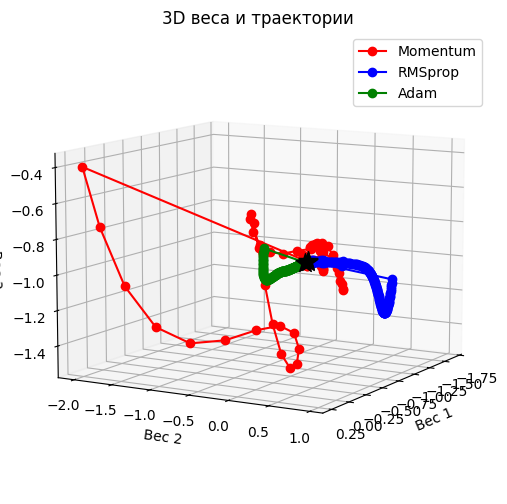

In [292]:
plot_weight_levels_3d(X_3, y_3, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

## m = 7

In [308]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_7, y_7, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_7, y_7, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_7, y_7, eps=0.05)

[-1.75049946e+75 -4.92964974e+75 -9.46296362e+75 -1.25000595e+76
 -1.76142529e+76 -2.25341941e+76 -3.22412591e+76]
[-0.54292234  0.33922905 -1.24747459  1.56360372  0.57988201  0.03171624
 -0.72701266]
[-0.55709694  0.74076793 -1.31713193  0.87611813  0.98193496  0.01326319
 -0.71018007]


Для маленькой размерности m = 2 ничего не поменялось, методы дают схожие между собой результаты и при меньшем learning rate. 

Для m = 3 теперь Adam дает аналогичный двум другим методам результат. Думаю, это связано с тем, что при уменьшении learning rate Adam теряет часть своего адаптивного преимущества (он тоже начинает двигаться медленнее).

Для m = 7 все равно для метода моментов происходит взрыв градиента

### в списке параметров уменьшаю $\beta$ (момент инерции)

In [ ]:
steps = 200
alpha = 0.001
beta = 0.8
epsilon = 1e-8
beta1, beta2 = 0.8, 0.85

# m = 2

[-0.64714623  0.07760982]
[-0.62086786  0.07186289]
[-0.56996483  0.05110228]


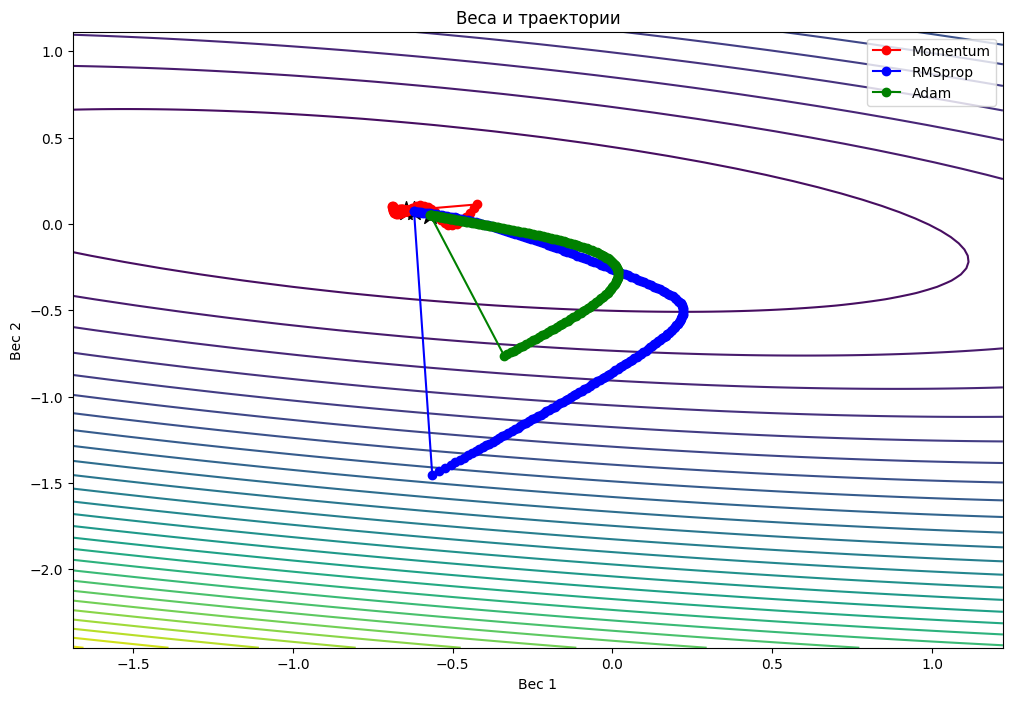

In [318]:
# Выполнение трех методов
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X, y, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X, y, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X, y, eps=0.05)

# Визуализация
plot_weight_levels(X, y, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

# m = 3

[-1.21790703 -0.40696572 -1.03486245]
[-1.40666441 -0.39797245 -1.00845589]
[-1.24743205 -0.45019808 -0.9977355 ]


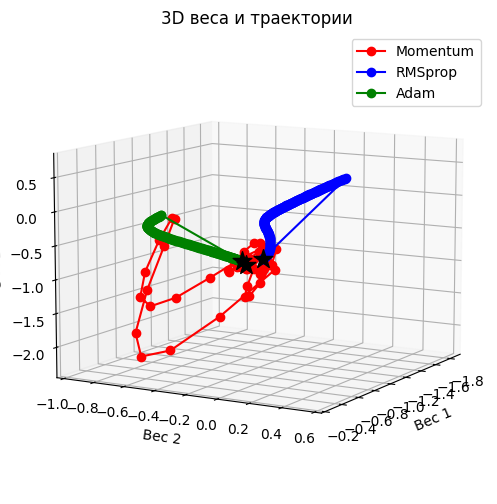

In [331]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_3, y_3, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_3, y_3, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_3, y_3, eps=0.05)

plot_weight_levels_3d(X_3, y_3, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

# m = 7

In [336]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_7, y_7, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_7, y_7, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_7, y_7, eps=0.05)

[2.60835252e+75 7.34548318e+75 1.41004014e+76 1.86258622e+76
 2.62463269e+76 3.35773437e+76 4.80414712e+76]
[ 2.08121913  0.70781748 -2.00777648  0.66040732  0.85528286  0.10617717
 -0.61465179]
[ 2.05097251  1.27746173 -1.28918778 -0.04404212  0.62241327  0.0470503
 -0.49579908]


Теперь для m = 2 и m = 3 Adam отличается немного от двух других методов. И уменьшение параметра $\beta$ опять не спасло метод инерции от переполнения. Но зато RMSprop и Adam дают идентичные результаты (=> сходятся к одному ответу)

### в списке параметров уменьшаю число шагов

In [339]:
steps = 50
alpha = 0.001
beta = 0.8
epsilon = 1e-8
beta1, beta2 = 0.8, 0.85

# m = 2

[-0.10422878 -0.02317314]
[0.61824289 0.41051241]
[0.25178904 0.35823304]


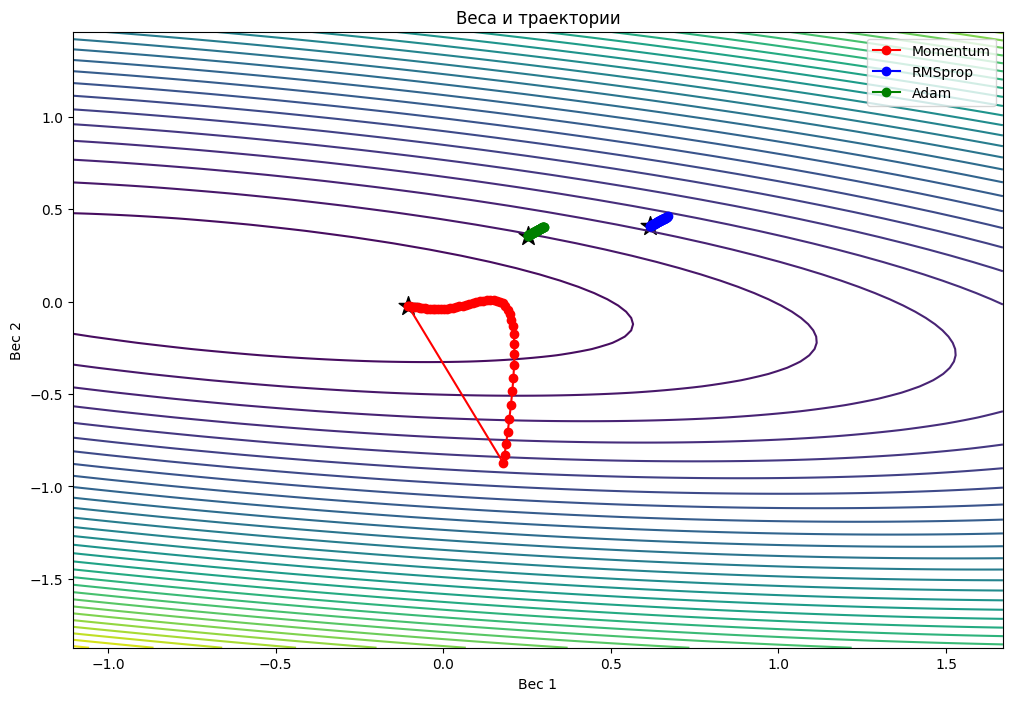

In [340]:
# Выполнение трех методов
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X, y, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X, y, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X, y, eps=0.05)

# Визуализация
plot_weight_levels(X, y, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

# m = 3

[ 0.08177197 -0.57230943 -1.12267083]
[-0.24772963  0.42915134  0.01941684]
[0.14341942 0.811626   1.09627198]


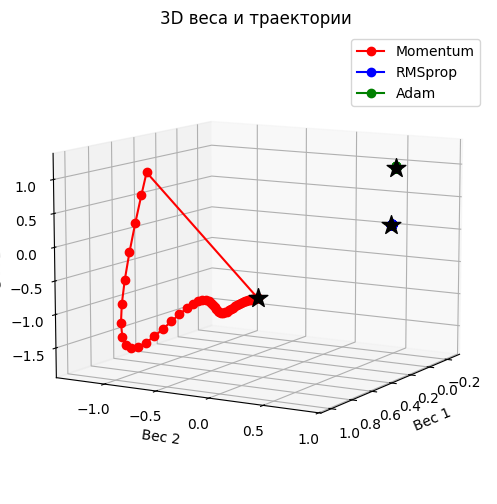

In [342]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_3, y_3, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_3, y_3, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_3, y_3, eps=0.05)

plot_weight_levels_3d(X_3, y_3, [history_momentum, history_rmsprop, history_adam], ['Momentum', 'RMSprop', 'Adam'])

# m = 7

In [343]:
w_momentum, history_momentum, _ = gradient_descent_momentum(steps, alpha, beta, X_7, y_7, eps=0.05)
w_rmsprop, history_rmsprop, _ = gradient_descent_rmsprop(steps, alpha, beta, epsilon, X_7, y_7, eps=0.05)
w_adam, history_adam, _ = gradient_descent_adam(steps, alpha, beta1, beta2, epsilon, X_7, y_7, eps=0.05)

[-0.9886819   0.1181683  -2.32060759  1.64651496  1.1177321   0.05426746
 -0.68418999]
[ 0.48798586  1.19634352  0.41737219 -0.43593812  1.20846487 -0.58076236
 -0.53703278]
[ 1.73724594  2.31428339  0.28744638  0.64068891 -1.05853516 -0.96683489
  0.57490656]


В целом, очевидно, что при маленьком кол - ве шагов все три метода будут давать разные резульаты, потому что каждый метод обновляет веса по-разному:

* Momentum накапливает градиент, но при малом числе шагов он может ещё не разогнаться.

* RMSprop адаптивно уменьшает шаги по разным направлениям, но тоже требует времени для стабилизации.

* Adam сочетает оба подхода, но в первые итерации его корректировки могут быть нестабильными.

При недостаточном числе шагов оптимизация останавливается на разных промежуточных точках, а значит, веса у каждого метода будут отличаться.

Но зато теперь метод моментов не переполнился и сошелся. Ура!

# Вывод

Итак, 

Анализ методов оптимизации показал, что их поведение зависит от размерности задачи, числа итераций и гиперпараметров.

На небольших размерностях (2, например) все три метода в целом сходятся к одному и тому же результату, при увеличении размерности (даже уже от 3х) Adam начинает отклоняться Momentum и RMSprop. А при совсем больших размерностях метод моментов исптывает градиентный взырыв и выдает неверные значения. 

Но если уменьшить число шагов, то этого можно избежать, однако тогда все 3 метода будут давать разные результаты. Очевидно, что если увеличить число шагов, то методы либо сойдутся к одному значению (если минимум чёткий), либо сохранят различия (если ландшафт функции ошибки сложный).

Уменьшение learning rate ($\alpha$)  и момента инерции ($\beta$) помогает избежать градиентного взрыва в методе моментов и способствует схождению всех методов к одному и тому же результату. Это происходит потому, что меньшие значения $\alpha$ и $\beta$ уменьшают влияние накопленных градиентов и делают обучение более стабильным.